Author: Abdulrahman Altahhan, 2025

The notebook uses a library of functionality in RL that aims for simplicity and general insight into how algorithms work, these libraries are written from scratch using standard Python libraries (numpy, matplotlib etc.).
Please note that you will need permission from the author to use the code for research, commercially or otherwise.

# Introduction to Bootstrapping
In this and subsequent units, we cover a set of RL algorithms that use bootstrapping, a powerful idea that allows us to create online updates that do not wait until the end of an episode to learn from the experience, live as it comes. We will continue on the tabular method, cover planning, and then move to function approximation methods. Along the way, we cover encoding techniques for state space traditionally used in RL, such as tile coding. On the function approximation, we will assume a linear model in this unit. We cover non-linear models from an application perspective in the subsequent unit. We are mainly concerned with regression not classification from a machine learning perceptive.

The settings are still the same as that of an MDP. However, we assume that the state space is large and may not be practical to represent each state as an entry in a table. The states might also not manifest themselves clearly, and only we can obtain some observations about them. These observations result in a set of numerical, categorical or boolean features which we can then numerically deal with them as we did in earlier modules.

# Worksheet 9- Tabular Methods: Temporal Difference Learning

**Learning outcomes**
1. understand the idea of bootstrapping and how it is being used in TD
2. understand the differences between MC and TD and appreciate their strengths and weaknesses
3. understand how to use the ideas of TD to extend it to a control method such as Sarsa and Q-learning


**Reading**:
The accompanying reading of this lesson is **chapter 6** of our text book available online [here](http://incompleteideas.net/book/RLbook2020.pdf). Please note that we explain the ideas of this topic from a practical perspective and not from a theoretical perspective which is already covered in the textbook.

In this lesson, we cover the Temporal Difference learning method. TD is one of the fundamental ideas in RL. It uses bootstrapping to improve its predictions. The idea behind bootstrapping is to use (own estimation) to improve (own estimation) with an indication from the ground truth in the form of a reward. This sound surprising since we are not using a direct ground truth to revert to when we are improving the prediction. However, it turns out that there are theoretical guarantees that the method will converge to a solution that is usually *close to optimal*. The one constant stream of ground truth the agent keeps receiving is the rewards in each state. One of the major strengths of TD is that it can be used online without having to wait till the end of the episode as we did in the Monte Carlo methods. This also makes it extremely efficient and allows it to converge faster *in practice *than MC. TD uses ideas similar to what we did in GPI: slightly improving the prediction and *not* waiting until everything is clear (at the end of an episode). This idea is similar to what we did in stochastic mini-batch updates in ML. We will call it eagerness to learn. I.e., to grab whatever information is available and whenever it becomes available but at the same time keep accumulating a stock of this information to help us improve and sharpen our prediction. We will then move into designing control algorithms that depend on TD, we will tackle old and new algorithms, including Sarsa, Expected Sarsa, Q-learning and double Q-learning, and we will test them extensively using the infrastructure that we developed in the previous lesson. Finally, we conclude by studying a policy gradient algorithm for control, namely actor-critic, that depends on TD and REINFORCE.

As usual, we will take a practical/pragmatic approach to cover the material and leave the theory to the book, which is well covered. Note that there are far more rigorous books that take special care for the mathematics guarantees behind the ideas of RL, which are not covered in our textbook [Introduction to Reinforcement Learning](http://incompleteideas.net/book/RLbook2020.pdf) but can be found in operation research books such as [Neuro-Dynamic Programming](http://web.mit.edu/jnt/www/ndp.html).

**Plan**
As usual, in general there are two types of RL problems that we will attempt to design methods to deal with 
1. Prediction problem
For These problems we will design Policy Evaluation Methods that attempt to find the best estimate for the value-function given a policy.


2. Control problems 
For These problems we will design Value Iteration methods which utilise the idea of Generalised Policy Iteration. They attempt to find the best policy, via estimating an action-value function for a current policy then moving to a better and improved policy by choosing a greedy action often. We will then move to Policy Gradient methods that directly estimate a useful policy for the agent by maximising its value function.


In [1]:
%matplotlib inline

In [2]:
from rl.rl import *

Ok, so we start by implementing the TD algorithm. Due to the way we structured our code and classes, it is relatively simple and straightforward to define any online and offline methods. TD is an online method that will be called in *each step during an episode*. We, therefore, can turn off the storage because we do not need it, but leaving it will not hurt the grid problems we are tackling. It will consume some memory and a few extra milliseconds of processing. For more difficult problems, we need to utilise the memory to train anyway, as we shall see in the Application unit.

We also would need to pass a learning step as we did for the MC algorithm. A learning step dictates how much error percentage will be considered when we update the value function. Sometimes we could go all the way α=1 when the algorithm is tabular, and the problem is simple. For most of the problems and algorithms we tackle, however, this is not desirable, and we set α=.1 or less to ensure the algorithm performs well on the common states and is acceptable on less common states. MC, however, is particularly sensitive towards this α, and we often would need to set it to smaller values such as .01.

In [3]:
class TD(MRP):
    # def stop_exp(self):
        
    # ----------------------------- 🌖 online learning ----------------------    
    def online(self, s, rn,sn, done, *args): 
        self.V[s] += self.α*(rn + (1- done)*self.γ*self.V[sn] - self.V[s])

Note how we multiplied the value $V[s_{t+1}]$ by (1- done). This is to ensure that when the episode is finished (ex., the agent is at goal or has achieved the task), we want only the final reward $r_{t+1}$ to participate in the update and not $V[s_{t+1}]$. This multiplication will appear in all of the updates we use. This saves us from having to treat the goal states in a special way on the environment level (ex. we could have set the value $V[s_{t+1}]$=0 by checking if $s_{t+1}==goal$ or by checking done in the environment or by treating done inside the s_() function when we use function approximation in later lessons). We felt that this would disguise this information, and it is always better to be explicit when possible.

Note also that we didn't use *a* and *an* in the online() function because we are making predictions in TD (no control yet). In addition, we do not store the experience for this one-step online algorithm while we had to for MC, which is again one of the advantages of online methods.

Let us test our brand new TD algorithm on the random walk prediction problem. Note that randwalk is the default environment for MRP anyway and hence no need to pass it.

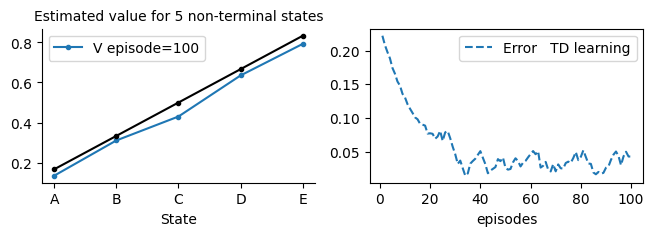

In [4]:
TDwalk = TD(episodes=100, v0=.5, **demoV())
TDwalk.interact(label='TD learning')

In [5]:
TDwalk.store

False

Note that we did not need to store the episodes trajectories in a pure online method, hence these methods are usually more memory efficient that there offline counterpart!
Note how TD performed far better and converged faster in fewer episodes than MC

Of course we can call interact immediately  as follows.

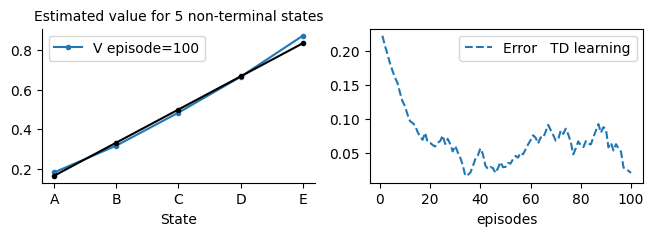

In [6]:
TDwalk = TD(episodes=100, v0=.5, **demoV()).interact(label='TD learning')

### Offline TD
In this section, we develop an offline TD algorithm. This is not a common algorithm as it usually defies the reason for using TD. That is, we usually use TD because it is an online algorithm. Nevertheless, studying this algorithm allows us to appreciate the strengths and weaknesses of TD and to compare its performance with other offline algorithms, such as MC.

In [7]:
class TDf(MRP):

    def init(self):
        self.store = True
    
    # ----------------------------- 🌘 offline TD learning ----------------------------   
    def offline(self):
        #for t in range(self.t, -1, -1):
        for t in range(self.t+1):
            s = self.s[t]
            sn = self.s[t+1]
            rn = self.r[t+1]
            done = self.done[t+1]
            
            self.V[s] += self.α*(rn + (1- done)*self.γ*self.V[sn]- self.V[s])


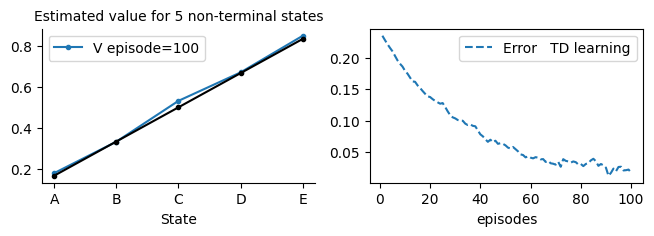

In [8]:
TDwalk = TDf(α=.05, episodes=100, v0=.5, **demoV()).interact(label='TD learning')

Note how we overrode the offline function in our MRP class that we covered in the previous lesson.
The first three lines inside the for loop are to make the update format of the online and offline identical.
We could have also made the algorithm go backwards, similar to MC. Each has its advantage and disadvantage, although for TD since it uses the temporal difference error, it usually makes little difference. You can uncomment the backward loop and try it yourself.

## Conducting trials(several runs) of experiments

Let us now create a useful handy class that summarizes several runs for us to reach a reliable and unbiased conclusions when we compare algorithms performances.

In [9]:
class Runs: # experimental trials

    def __init__(self, 
                 algorithm=None,
                 runs=10, 
                 plotR=False, 
                 plotT=False, 
                 plotE=False,
                 **kw): 
        
        self.algorithm = algorithm if algorithm is not None else MRP(**kw)
        self.runs = runs
        self.plotR = plotR
        self.plotT = plotT
        self.plotE = plotE
        
       
    def header(self):
        return 'runs|'          + self.algorithm.header()
    def values(self, results):
        return '%4d|'%self.runs + self.algorithm.values(results)
   
    def init(self):
        np.random.seed(1)# for binomial, choice and randint
        random.seed(1)   # for using choices
        
        self.Rs = np.zeros((self.runs, self.algorithm.episodes))
        self.Ts = np.zeros((self.runs, self.algorithm.episodes))
        self.Es = np.zeros((self.runs, self.algorithm.episodes))
    
    def isplot(self):
        return self.plotR or self.plotT or self.plotE

    def interact(self, label='', frmt='-', **kw):
        self.init()
        runs,  algorithm = self.runs, self.algorithm
        if not label: 
            label = 'no label passed'
        
        start_time = time.time()
        for self.run in range(runs):
            run = self.run

            # visual env in the last run, usually no need to visualise other runs
            visual = algorithm.visual and run==runs-1  
            label_ = ', run=%d'%(run+1)
            
            algorithm = algorithm.interact(visual=visual, label=label_, seed=run, **kw)
            self.Rs[run] = algorithm.Rs 
            self.Ts[run] = algorithm.Ts
            self.Es[run] = algorithm.Es            
            self.runstime = progress(self.run, runs, start_time, self.isplot())
        
        if self.isplot(): self.plot(label, frmt)
        
        return self
            
    def plot(self, label='', frmt='-') :
        Rs, Ts, Es, algorithm = self.Rs, self.Ts, self.Es, self.algorithm
        label_ =' averaged over %d runs'%(self.runs)
        if self.plotT: plt.plot(algorithm.eplist, Ts.mean(0), frmt, label=label); plt.xlabel('episodes,'+label_); plt.legend()
        if self.plotR: plt.plot(algorithm.eplist, Rs.mean(0), frmt, label=label); plt.xlabel('episodes,'+label_); plt.legend()
        if self.plotE: plt.plot(algorithm.eplist, Es.mean(0), frmt, label=label); plt.xlabel('episodes,'+label_); plt.legend()
        
        return self

# ============================ useful progress bar ======================================
'''
    useful progress bar function we can use tqdm but it does not play well sometime
'''
def progress(i, I, start, show=True, color=0):
    if show:
        percent = int(100 * (i+1)//I)
        print(f'\r{percent}%|\033[9{color}m{"█" * int(percent*.9)}\033[0m|{i+1}/{I}', \
              end='\r' if i+1<I else '\n')

    return int((time.time()- start)*1000)

Note how the class allows us to run several experiments efficiently. The main assumption is that the algorithms are inherited from an MRP class which applies for the majority of the classes that we will deal with in our units.

Let us now see how we can use this new class to easily run experiments to study how an algorithm behaves. Below we show a function that compares TD with MC on different learning rates. You can read about this comparison and the associated figure in Example 6.2 of the book (hence the function's name). We will follow this trend of naming functions after their counterpart examples or figures in the book.

100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100


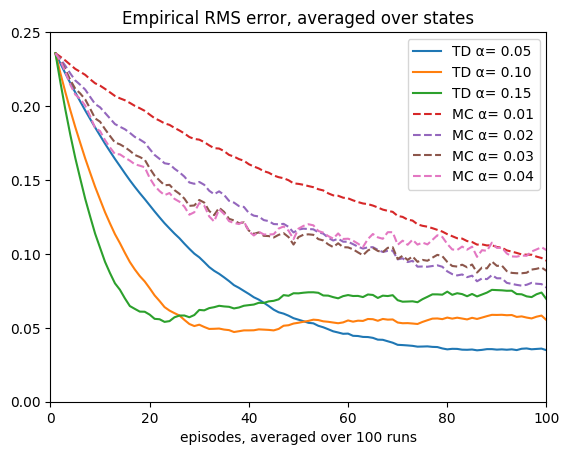

In [10]:
def TD_MC_randwalk(env=randwalk(), alg1=TDf, alg2=MC):
    plt.xlim(0, 100)
    plt.ylim(0, .25)
    plt.title('Empirical RMS error, averaged over states')
    
    for α in [.05, .1, .15]:
        TDαs = Runs(algorithm=alg1(env=env, α=α, v0=.5), runs=100, plotE=True).interact(label='TD α= %.2f'%α, frmt='-')

    for α in [.01, .02, .03, .04]:
        MCs = Runs(algorithm=alg2(env=env, α=α, v0=.5), runs=100, plotE=True).interact(label='MC α= %.2f'%α, frmt='--')

def example_6_2(**kw): return TD_MC_randwalk(**kw)

example_6_2()

We have already imported MC to compare its performance with our newly defined offline TD. Remember that MC is also offline algorithm.

Note that we could have simply defined  

example_6_2=TD_MC_randwalk

and then call it as

example_6_2()

but that would make importing it in other lessons harder.

## Optimality of TD
In this section, we study the optimality of TD. We develop two algorithms, Batch TD and Batch MC. Both of these algorithms operate in a **supervised learning fashion**. We collect a set of episodes and then deal with them as mini-batches, and then we run a set of epochs that repeatedly present the so-far experience until the algorithm converges. We use TD and MC updates inside the algorithm to see which value each converges to. By doing so, we have levelled up the strength of both algorithms (both are offline and wait until the end of each episode to accommodate all past experiences after each episode), and we laid their performance on pure convergence terms.

In [11]:
class MRP_batch(MRP):
    
    def __init__(self, **kw):
        super().__init__(**kw)
        self.store = True # store the full experience

    # we will redfine the allocate to store the full experience instead of only latest episode
    def allocate(self): 
        self.r = np.zeros((self.max_t, self.episodes))
        self.s = np.ones ((self.max_t, self.episodes), dtype=np.uint32) *(self.env.nS+10)  
        self.a = np.zeros((self.max_t, self.episodes), dtype=np.uint32)  # actions and states are indices        
        self.done = np.zeros((self.max_t, self.episodes), dtype=bool)
        
    def store_(self, s=None,a=None,rn=None,sn=None,an=None, done=None, t=0):
        # store one trajectory(sarsa) in the rigth episode buffer
        if s  is not None: self.s[t, self.ep] = s
        if a  is not None: self.a[t, self.ep] = a
        if rn is not None: self.r[t+1, self.ep] = rn
        if sn is not None: self.s[t+1, self.ep] = sn
        if an is not None: self.a[t+1, self.ep] = an
        if done is not None: self.done[t+1, self.ep] = done

    # returns the agent's trace from latest episode buffer
    def trace(self):
            return self.s[:self.t+1, self.ep]

Below we inherit the above class to allow us to conduct batch TD learning. This form of learning is usually not practical, but it is listed here for studying the behaviour of TD to gain insight into what kind of target it has and compare it with MC. The point is to prove that TD, in practice, indeed has a different goal than MC and is more efficient in converging to this target, which in turn, usually reduces the error more effectively than MC does.

In [12]:
class TD_batch(MRP_batch):
    def __init__(self, α=.001, **kw):
        super().__init__(α=α, **kw)

    # -----------------------------------🌘 offline learning------------------------------------- 
    def offline(self):
        # epochs
        while True:
            ΔV = self.V*0
            # each episode acts like a mini-batch in supervised learning
            for ep in range(self.ep+1): 
                for t in range(self.Ts[ep]):#-1, -1, -1):
                    s  = self.s[t, ep]
                    sn = self.s[t+1, ep]
                    rn = self.r[t+1, ep]
                    done = self.done[t+1, ep]
                    
                    ΔV[s] += rn + (1- done)*self.γ*self.V[sn]- self.V[s]
            ΔV *= self.α
            # exit the epochs loop if there is no more meaningful changes (method converged)
            if np.abs(ΔV).sum() < 1e-3:  break #; print('exit')
            self.V += ΔV

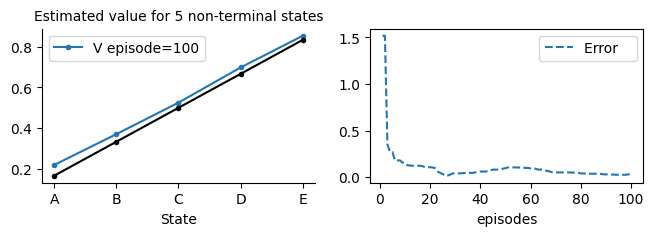

In [13]:
TDwalk_batch = TD_batch(episodes=100, v0=-1, **demoV()).interact()

Note how the batch updates have much smoother and faster convergence per-episodes than a usual TD or MC. However, they have a much higher computational cost that makes them not suitable for practical problem.

In [14]:
class MC_batch(MRP_batch):
    def __init__(self, α=.001, **kw):
        super().__init__(α=α,**kw)
    
    # -----------------------------------🌘 offline learning------------------------------------- 
    def offline(self):
        # epochs
        while True:
            ΔV = self.V*0
            # each episode acts like a mini-batch in supervised learning
            for ep in range(self.ep+1):
                Gt = 0
                for t in range(self.Ts[ep]-1, -1, -1):
                    s  = self.s[t, ep]
                    rn = self.r[t+1, ep]
                    
                    Gt = rn + self.γ*Gt 
                    ΔV[s] += Gt - self.V[s]
            
            ΔV *= self.α
            # exit the epochs loop if there is no more meaningful changes (method converged)
            if np.abs(ΔV).sum() < 1e-3: break #;print('exit')
            self.V += ΔV

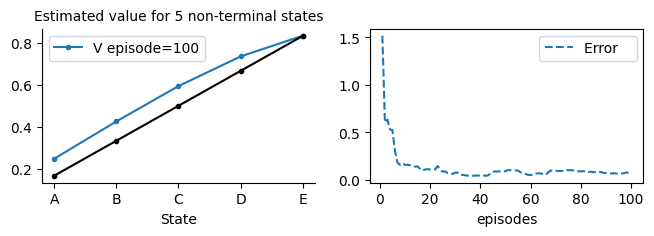

In [15]:
MCwalk_batch = MC_batch(episodes=100, v0=-1, **demoV()).interact()

### Batch runs
Now it is time to run experiments to specify which algorithm is better. We follow the experiments conducted in figure 6.2 in the book. Note that we initialise to -1 this time to smoothen the resultant figure and remove any advantages the algorithms had when starting from .5 probabilities. This means that the algorithm would have to guess all the way from -1 to the probability of starting in a state s and ending up in the right terminal state. 

We start with 10 runs to show the full range that the algorithm will take in the early episodes, and then in the definition of figure_6_2( ), we restrict the figure's limit to show the interesting trend of each algorithm. Note that the algorithms could have been made more efficient by some further optimization which we left out for pedagogical reasons.

100%|██████████████████████████████████████████████████████████████████████████████████████████|3/3
100%|██████████████████████████████████████████████████████████████████████████████████████████|3/3


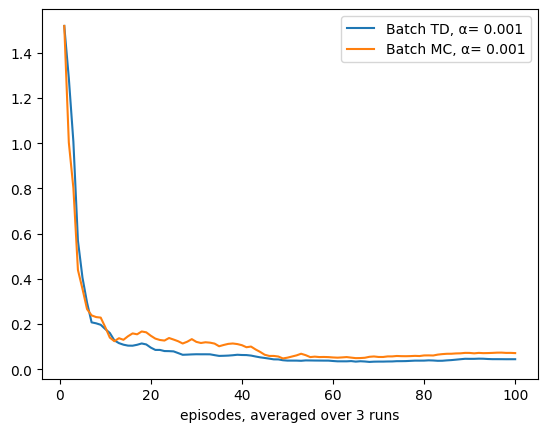

In [16]:
α=.001
TDB = Runs(algorithm=TD_batch(v0=-1, α=α, episodes=100), runs=3, plotE=True).interact(label= 'Batch TD, α= %.3f'%α)
MCB = Runs(algorithm=MC_batch(v0=-1, α=α, episodes=100), runs=3, plotE=True).interact(label='Batch MC, α= %.3f'%α)


In [17]:
def figure_6_2():
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlim(0,100)
    plt.ylim(0, .25)
    plt.title('Batch Training')

    α=.001
    TDB = Runs(algorithm=TD_batch(v0=-1, α=α, episodes=100), runs=100, plotE=True).interact(label= 'Batch TD, α= %.3f'%α)
    MCB = Runs(algorithm=MC_batch(v0=-1, α=α, episodes=100), runs=100, plotE=True).interact(label='Batch MC, α= %.3f'%α)

100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100


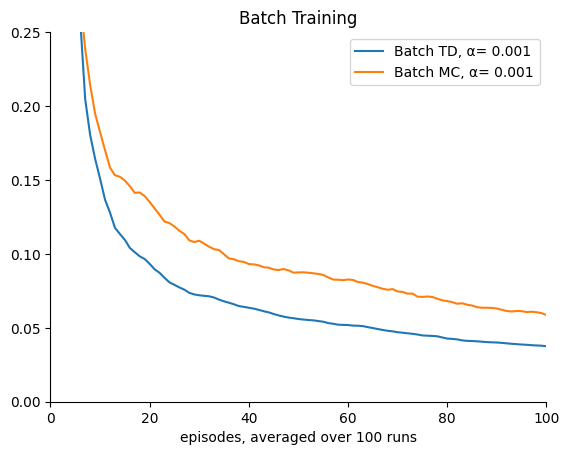

In [18]:
figure_6_2()

## TD Control 
In this section, we deal with TD control. We cover mainly two algorithms one is Sarsa which is an on-policy control algorithm (meaning the followed policy is the same as the policy we are learning about). The second main algorithm is the famous Q-learning algorithm which is an off-policy algorithm. In the case of Q-learning, the agent is acting according to an ε-greedy algorithm while it is learning about a greedy algorithm.

Similar to what we did earlier we will use the two dictionaries demoQ and demoR to make the calls more concise.

## Sarsa on-policy control

In [19]:
class Sarsa(MDP()):
    
    def init(self): #α=.8
        self.step = self.step_an # for Sarsa we want to decide the next action in time step t
    
    # ----------------------------------------🌖 online learning ----------------------------------------
    def online(self, s, rn,sn, done, a,an):
        self.Q[s,a] += self.α*(rn + (1- done)*self.γ*self.Q[sn,an] - self.Q[s,a])

Note that we do not store the experience for this one-step online algorithm while we had to for MC, and this is again one of the advantages of online methods.

Let us now apply the Sarsa on a simple grid world environment. The goal is directly facing the start position. However, to make the problem more difficult for the algorithm we have deprioritised the right action and we place the order of the actions as follows: left, right, down and up. This simple change made the agent pick going left before going right and made the problem only a bit more difficult. Let us see how the Sarsa performs on it.

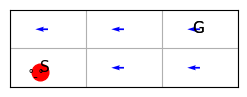

In [20]:
env2x3 = Grid(gridsize=[2, 3], reward='reward_', s0=0, goals=[5], figsize=[10,1])
env2x3.render(underhood='maxQ')

In [21]:
Qs1 = np.array([.1,	.4	,.0	, .3])
(np.exp(Qs1)/np.exp(Qs1).sum()).round(2)

array([0.22, 0.3 , 0.2 , 0.27])

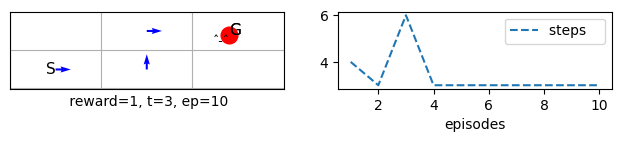

In [22]:
sarsa = Sarsa(env=env2x3, α=.1, γ=.9, episodes=10, store=True, seed=0, **demoQ())
sarsa.interact()

In [23]:
sarsa.s[:sarsa.t+2]

array([0, 1, 4, 5], dtype=uint32)

In [24]:
sarsa.Q

array([[0.        , 0.05685457, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.23751096],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.65132156, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

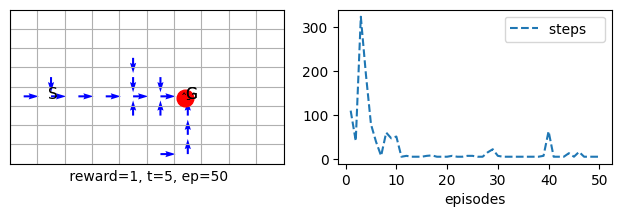

In [25]:
sarsa = Sarsa(env=grid(), α=.8, episodes=50, seed=10, **demoQ()).interact()

CPU times: user 4.85 s, sys: 416 ms, total: 5.26 s
Wall time: 3.89 s


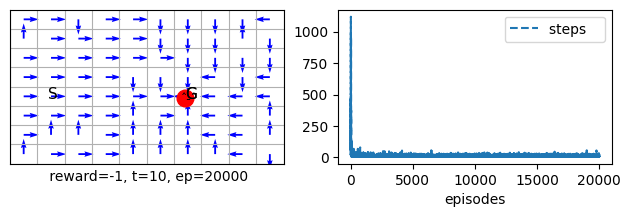

In [26]:
%time sarsa = Sarsa(env=grid(reward='reward_1'), q0=10, ε=.4, α=.3, episodes=20000, seed=1, **demoQ()).interact()

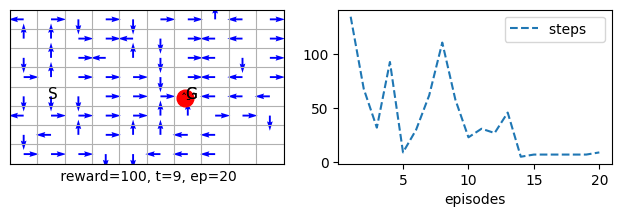

In [27]:
sarsa = Sarsa(env=grid(reward='reward100'), α=.3, episodes=20, seed=1, **demoQ()).interact()

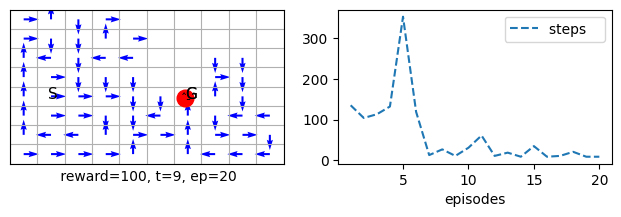

In [28]:
mc = MCC(env=grid(reward='reward100'), α=.3, episodes=20, seed=1, **demoQ()).interact()

Note how Sarsa performed better and converged faster in fewer episodes than MCC

CPU times: user 60.4 ms, sys: 14.4 ms, total: 74.8 ms
Wall time: 25 ms


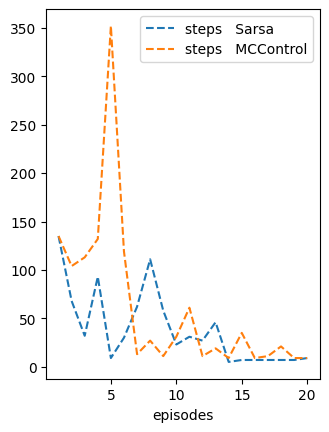

In [29]:
%time sarsa = Sarsa(env=grid(reward='reward100'),  α=.3, episodes=20, seed=1, plotT=True).interact(label='Sarsa')
%time mc = MCC(env=grid(reward='reward100'), α=.3, episodes=20, seed=1, plotT=True).interact(label='MCControl')

Of course we change the seed the performance will change for both. Also if we change the learning rate α the performance will vary (change the seed to 0 and run). This is why it is important to conduct several runs in order to obtain the performance of the algorithms on average.

In [30]:
def Maze(rows=6, cols=9, **kw):
    return Grid(gridsize=[rows,cols], s0=int((rows)/2)*cols, goals=[rows*cols-1], style='maze', **kw)

def maze_large(**kw):
    return Maze(rows=16, cols=26, figsize=[25,4],**kw)

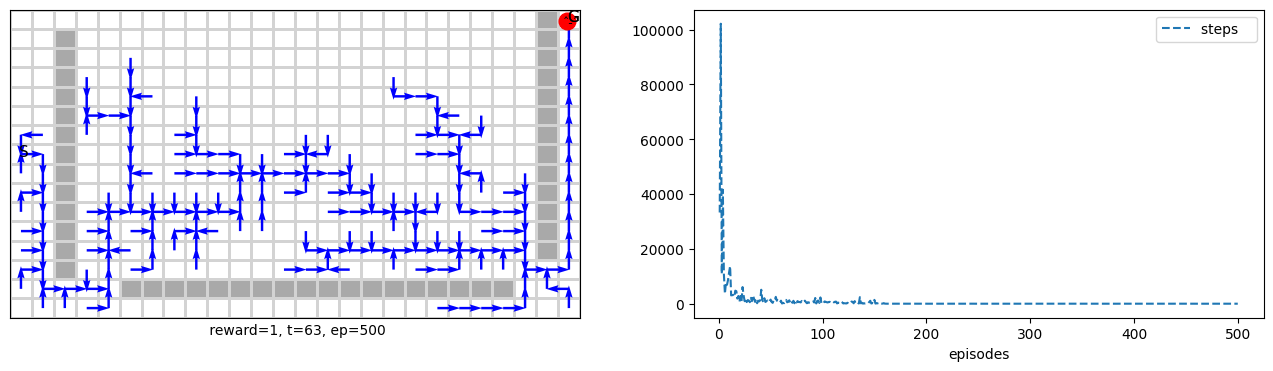

In [31]:
sarsa_large = Sarsa(env=maze_large(), α=.1, episodes=500, seed=0 , **demoQ()).interact()

### Changing actions priorities

To change the action priority we can do the following:

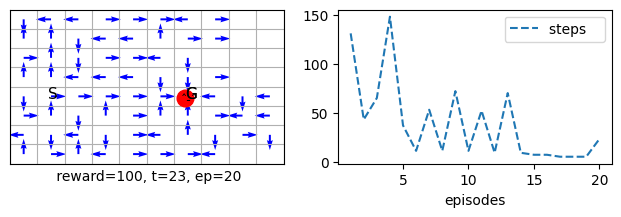

In [32]:
env = grid(reward='reward100')
env._right, env._left, env._up , env._down=tuple(range(0,4))
sarsa = Sarsa(env=env, episodes=20, seed=10, **demoQ()).interact()

Note how the new dynamics made the solution a bit easier. This makes more difference specifically for the MCC because it depends on explore-start.

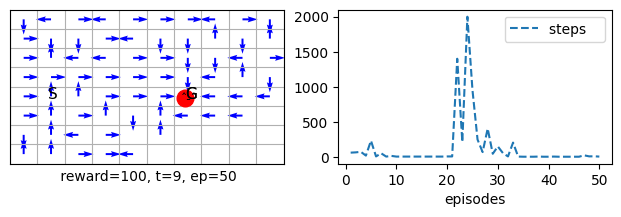

In [33]:
mc = MCC(env=env, α=.2, episodes=50, **demoQ()).interact()

## Sarsa on windy environment
In this section we show how Sarsa behaves on the windy environment that we have shown in lesson 2. The idea to show that TD is able of learning to deal with the upward wind in a manner that allows it to reach the goal effectively. This study can be seen in Example 6.5 in the book.

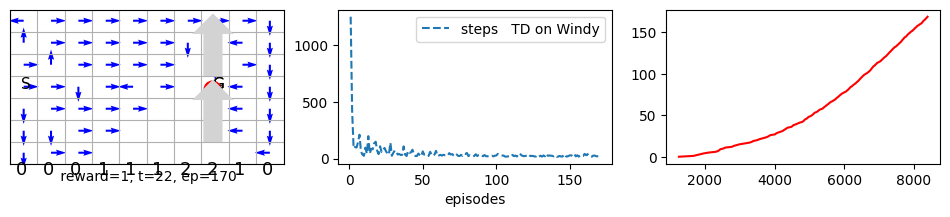

In [34]:
def Sarsa_windy():
    return Sarsa(env=windy(reward='reward1'), α=.5, seed=1, **demoQ(), episodes=170).interact(label='TD on Windy')
    
example_6_5 = Sarsa_windy

trainedV = example_6_5()

plt.subplot(133).plot(trainedV.Ts.cumsum(), range(trainedV.episodes),'-r')
plt.show()

## Q-learning off-policy control
Now we move to the Q-learning algorithm. Q-learning is one of the most successful algorithms in RL. Although it is an *off-policy* (not offline) algorithm, it usually performs better than the Sarsa. Q-learning also allowed for a control algorithm's first proof of convergence due to its simple update rules. 

**Important** Note that Q-learning does not require changing the step function because it does not require knowing the next action in advance (unlike Sarsa). Hence it uses a simple algorithmic schema that is almost identical to TD.


In [35]:
class Qlearn(MDP()):
    
    #--------------------------------------🌖 online learning --------------------------------------
    def online(self, s, rn,sn, done, a,_):
        self.Q[s,a] += self.α*(rn + (1- done)*self.γ*self.Q[sn].max() - self.Q[s,a])

As you can see, we did not use the action *an* in Qlearning() because we take the max of the action and assume that it is the one that the agent will pick (although this might not be the case, and hence it is an **off-policy** learning algorithm because we are learning about a fully greedy policy while the agent is acting according to an εgreedy policy). Also note that we do not store the experience for this one-step online algorithm while we had to for MC, which is again one of the advantages of online methods.

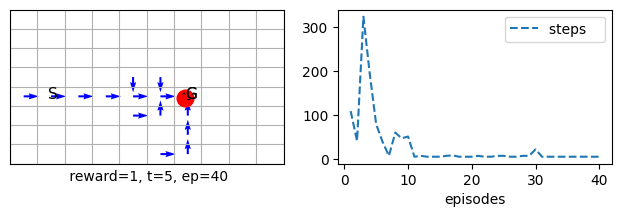

In [36]:
qlearn = Qlearn(env=grid(), γ=1, α=.8, episodes=40, seed=10, **demoQ()).interact()

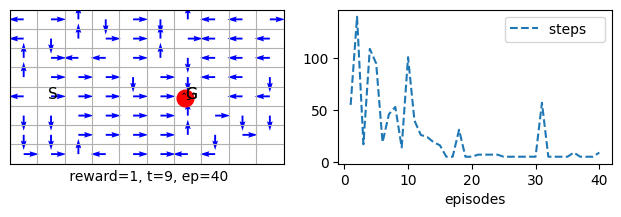

In [37]:
qlearn = Qlearn(env=grid(reward='reward1'), α=.8, episodes=40, seed=10, **demoQ()).interact()

## Sarsa and Q-Learning on a Cliff Edge!

This section compares the performance of on-policy Sarsa and off-policy Q-learning algorithms to show how each act on a specific problem. The problem that we will tackle is a cliff-edge world. This is a grid world of 12x4, with a goal location on the far-right bottom corner and the start location on the far-left bottom corner. There are no obstacles. However, there is a cliff between the start and the goal locations on the bottom. If the agent trespasses on it, it falls off the cliff, receives a penalty of -100 and will be relocated back to the start location *without starting a new episode*. The agent receives a reward of -1 everywhere, including the goal location. We will use the sum of rewards metric to measure the performance of algorithms on this problem.

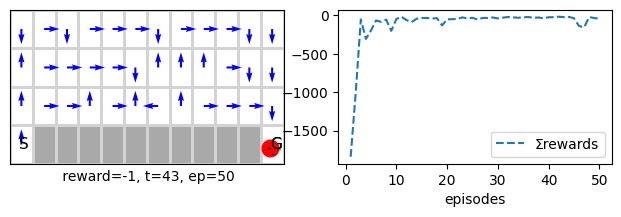

In [38]:
sarsa = Sarsa(env=cliffwalk(), α=.5, episodes=50, seed=1, **demoR()).interact()

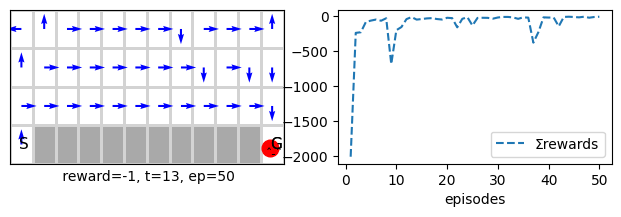

In [39]:
sarsa = Qlearn(env=cliffwalk(), α=.5, episodes=50, seed=1, **demoR()).interact()

In [40]:
def Sarsa_Qlearn_cliffwalk(runs=200, α=.5, env=cliffwalk(), alg1=Sarsa, alg2=Qlearn):
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)    
    plt.yticks([-100, -75, -50, -25])
    plt.ylim(-100, -10)

    
    SarsaCliff = Runs(algorithm=alg1(env=env, α=α, episodes=500), runs=runs, plotR=True).interact(label='Sarsa')
    QlearnCliff = Runs(algorithm=alg2(env=env, α=α, episodes=500), runs=runs, plotR=True).interact(label='Q-learning')
    return SarsaCliff, QlearnCliff

def example_6_6(**kw): return Sarsa_Qlearn_cliffwalk(**kw)

100%|██████████████████████████████████████████████████████████████████████████████████████████|200/200
100%|██████████████████████████████████████████████████████████████████████████████████████████|200/200


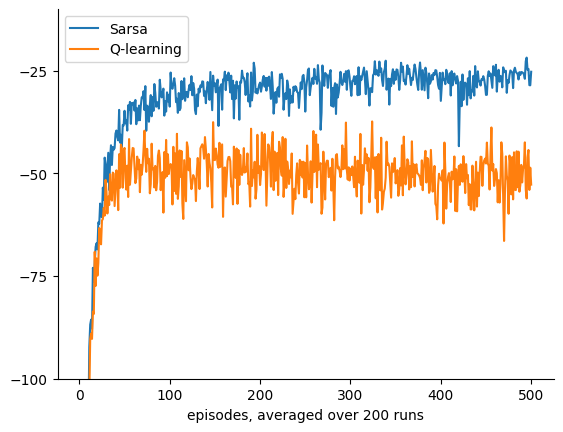

In [41]:
SarsaCliff, QlearnCliff = Sarsa_Qlearn_cliffwalk()

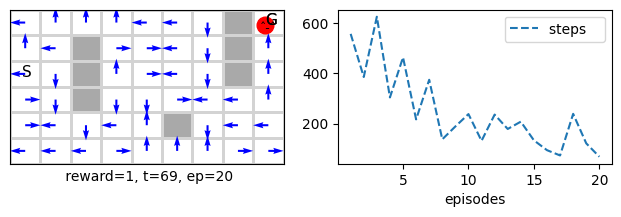

In [42]:
sarsa = Sarsa(env=maze(reward='reward1'), episodes=20, seed=10, **demoQ()).interact()

## Expected Sarsa
In this section, we cover the expected Sarsa algorithm. This algorithm is very similar to the Q-learning algorithm and has the same schematic structure (unlike Sarsa, it does not require obtaining the next action in advance). It takes all the probabilities of the different actions and forms an expectation of the next action.

In [43]:
class XSarsa(MDP()):

    # ------------------------------------- 🌖 online learning --------------------------------------
    def online(self, s, rn,sn, done, a,_):      
        # obtain the ε-greedy policy probabilities, then obtain the expecation via a dot product for efficiency
        π = self.π(sn)
        v = self.Q[sn].dot(π)
        self.Q[s,a] += self.α*(rn + (1- done)*self.γ*v - self.Q[s,a])

Note that the policy is assumed to be ε-greedy, if you want to deal with other policies then a different implementation is required

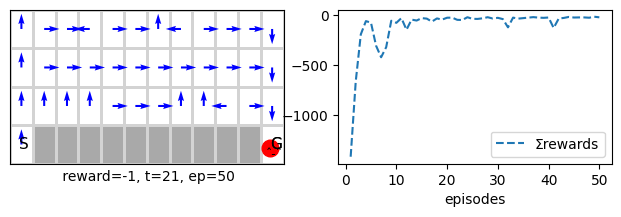

In [44]:
xsarsa = XSarsa(env=cliffwalk(), α=.5, episodes=50, seed=1, **demoR()).interact()

## Double Q-learning

In [45]:
class DQlearn(MDP()):

    def init(self):
        self.Q1 = self.Q
        self.Q2 = self.Q.copy()
        
    # we need to override the way we calculate the aciton-value function in our εgreedy policy
    def Q_(self, s=None, a=None):
            return self.Q1[s] + self.Q2[s] if s is not None else self.Q1 + self.Q2

    # ----------------------------- 🌖 online learning ----------------------
    def online(self, s, rn,sn, done, a,_): 
        p = np.random.binomial(1, p=0.5)
        if p:    self.Q1[s,a] += self.α*(rn + (1- done)*self.γ*self.Q2[sn].max() - self.Q1[s,a])
        else:    self.Q2[s,a] += self.α*(rn + (1- done)*self.γ*self.Q1[sn].max() - self.Q2[s,a])


## Comparing Sarsa, Expected Sarsa, Q-learning and Double Q-learning 

Ok now we can compare all 4 algorithms on the different environments to see their performances. 

### Comparison on cliff walking

In [46]:
def XSarsaDQlearnCliff(runs=300, α=.5):
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)    
    plt.yticks([-100, -75, -50, -25])
    plt.ylim(-100, -10)
    env = cliffwalk()

    XSarsaCliff = Runs(algorithm=XSarsa(env=env, α=α, episodes=500), runs=runs, plotR=True).interact(label='XSarsa')
    DQlearnCliff = Runs(algorithm=DQlearn(env=env, α=α, episodes=500), runs=runs, plotR=True).interact(label='Double Q-learning')

    return XSarsaCliff, DQlearnCliff

100%|██████████████████████████████████████████████████████████████████████████████████████████|300/300
100%|██████████████████████████████████████████████████████████████████████████████████████████|300/300


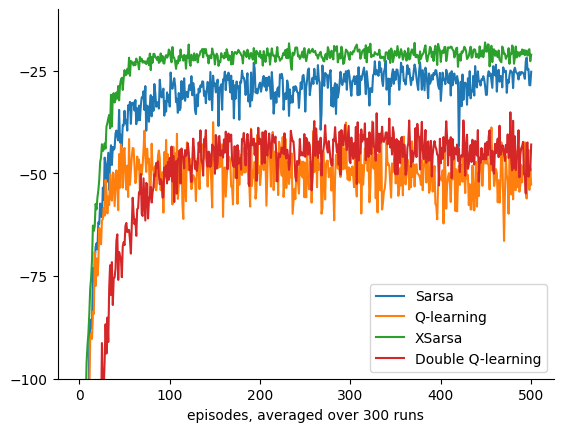

In [47]:
SarsaCliff.plot(label='Sarsa', frmt='-')
QlearnCliff.plot(label='Q-learning', frmt='-')
XSarsaCliff, DQlearnCliff = XSarsaDQlearnCliff()

### Comparison on the Maze

In [48]:
def compareonMaze(runs=100, α=.5):
    
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    
    env=Grid(gridsize=[10,20], style='maze', s0=80, reward='reward1') # this is bit bigger than the defualt maze
    env.render()
    
    SarsaMaze = Runs(algorithm=Sarsa(env=env, α=α, episodes=30), runs=runs, plotT=True).interact(label='Sarsa')
    XSarsaMaze = Runs(algorithm=XSarsa(env=env, α=α, episodes=30), runs=runs, plotT=True).interact(label='XSarsa')
    
    QlearnMaze = Runs(algorithm=Qlearn(env=env, α=α, episodes=30), runs=runs, plotT=True).interact(label='Q-learning')
    DQlearnMaze = Runs(algorithm=DQlearn(env=env, α=α, episodes=30), runs=runs, plotT=True).interact(label='Double Q-learning')

    return SarsaMaze, XSarsaMaze, QlearnMaze, DQlearnMaze

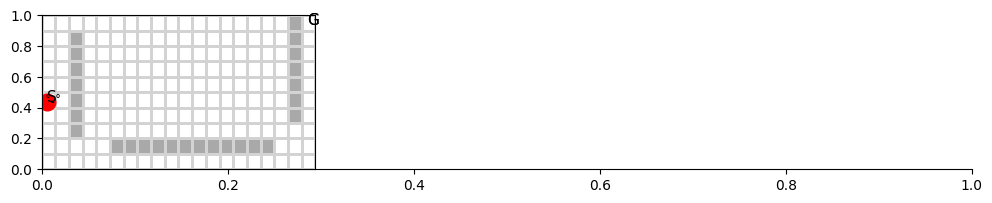

100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100


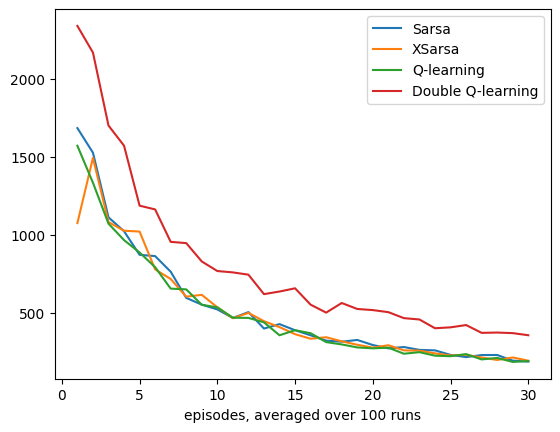

In [49]:
SarsaMaze, XSarsaMaze, QlearnMaze, DQlearnMaze = compareonMaze(α=.5)

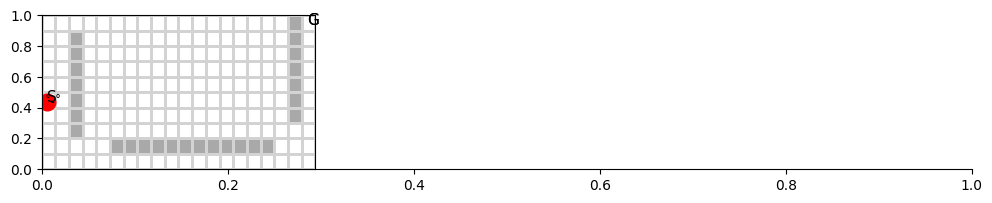

100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100


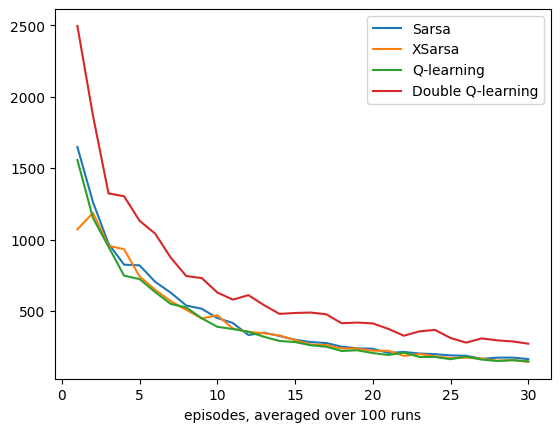

In [50]:
SarsaMaze, XSarsaMaze, QlearnMaze, DQlearnMaze = compareonMaze(α=.7)

## Actor-Critic: TD for Policy Gradient Methods
Earlier, we saw how REINFORCE could perform well in the grid environment. REINFORCE is a policy gradient method that attempts to directly estimate a policy instead of estimating an action-value function. This is done by using the value function as an objective function that we would want to *maximise* (instead of minimising an error function as in Sarsa or Q-learning).

Like Monte Carlo, REINFORCE is an offline method that needs to wait until the end of an episode to estimate the value function. The question, then, is there an algorithm similar to REINFORCE but online? The method should be derived similarly to Sarsa and Q-learning, which depends on the next step estimate of the value function.
The answer is yes, and the method is called Actor-critic, which does that exactly. The algorithm general unified update attempts to estimate its policy by directly *maximising the returns with respect to a baseline* (see section 13.4). When the algorithm replaces its returns with an estimate of the returns (section 13.5, the difference between the return estimate and the baseline becomes a TD error), the algorithm can be thought of as having two distinctive parts an actor and a critic. The actor maximises its *start-state-value function*, while the critic attempts to improve its *estimates* of the *state-value function* for all states. Both of them use the Temporal Difference (TD) error to improve their estimates, meaning they can work online. Like REINFORCE, the actor-critic uses a SoftMax policy to select an action according to the actor policy parameters. So, to maximise the value, the actor takes the derivative of the $ \nabla \log v(S_0)$. 

Actor-critic is one of the oldest RL algorithms, and it avoids several issues that arise from the use of $\epsilon$-greedy policy. The most obvious one is that the policy changes the *probability* of selecting an action gradually and continuously when the parameters change, unlike $\epsilon$-greedy, which can change the *maximum value action* abruptly due to a small change in the parameters. This also allows it to provide better convergence guarantees.

In [51]:
class Actor_Critic(PG()):
    
    def step0(self):
        self.γt = 1 # powers of γ, must be reset at the start of each episode
    
    def online(self, s, rn,sn, done, a,an): 
        π, γ, γt, α, τ, t = self.π, self.γ, self.γt, self.α, self.τ, self.t
        δ = (1- done)*γ*self.V[sn] + rn - self.V[s]  # TD error is based on the critic estimate

        self.V[s]   += α*δ                          # critic
        self.Q[s,a] += α*δ*(1- π(s,a))*γt/τ         # actor
        self.γt *= γ

### Delayed Reward
First let us establish the baseline performance

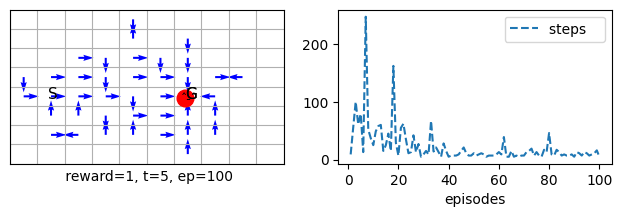

In [52]:
ac = Actor_Critic(env=grid(), α=1, τ=1, γ=1, episodes=100, seed=0 , **demoQ()).interact()

Note that we set α=1 which is unusual for an RL algorithm and the method just worked. This is a testimony to the resilience and strength of actor-critic methods. Let us test this further.

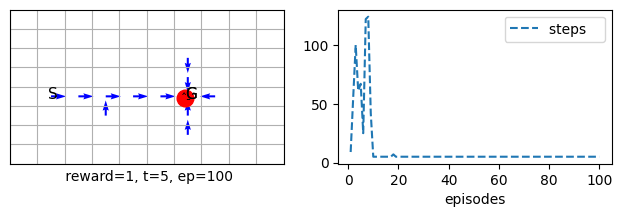

In [53]:
ac = Actor_Critic(env=grid(), α=1, τ=.3, γ=1, episodes=100, seed=0 , **demoQ()).interact()

Note how reducing the exploration factor $\tau=.3$ led to a much faster convergence.

Let us now reduce the learning rate instead.

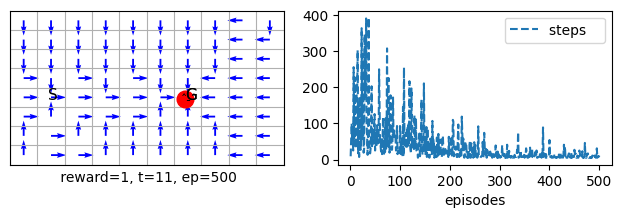

In [54]:
ac = Actor_Critic(env=grid(), α=.1, τ=1, γ=1, episodes=500, seed=0, **demoQ()).interact()

Note how we had to increase the number of episodes to converge when we set $\alpha=.1$ instead of $\alpha=1$.

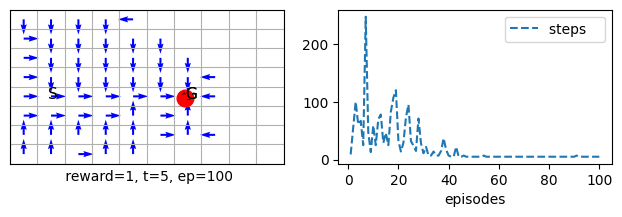

In [55]:
ac = Actor_Critic(env=grid(), α=.1, τ=.1, γ=1, episodes=100, seed=0, **demoQ()).interact()

Note how reducing both $\tau$ and $\alpha$ helped reach convergence quickly but with a better exploration.

Let us now reduce the discount factor $\gamma$

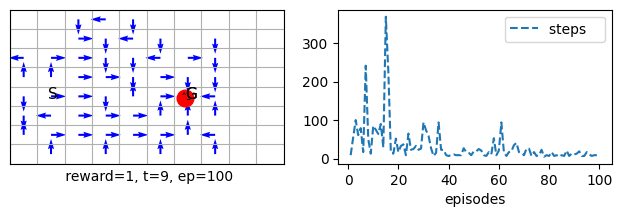

In [56]:
ac = Actor_Critic(env=grid(), α=1, τ=1, γ=.99, episodes=100, seed=0, **demoQ()).interact()

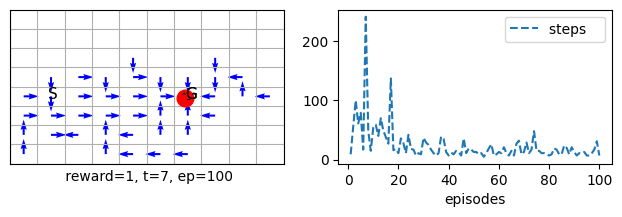

In [57]:
ac = Actor_Critic(env=grid(), α=1, τ=.97, γ=.99, episodes=100, seed=0, **demoQ()).interact()

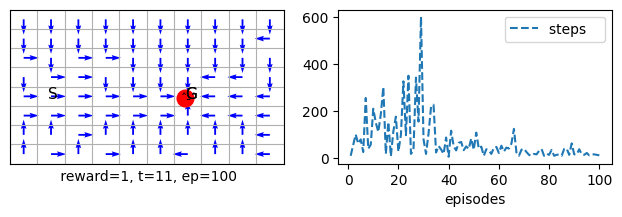

In [58]:
ac = Actor_Critic(env=grid(), α=.3, τ=1, γ=.99, episodes=100, seed=0, **demoQ()).interact()

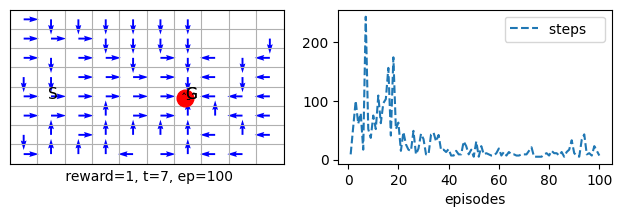

In [59]:
ac = Actor_Critic(env=grid(), α=.8, τ=.9, γ=.99, episodes=100, seed=0, **demoQ()).interact()

print(ac.Q)

### Intermediate Reward

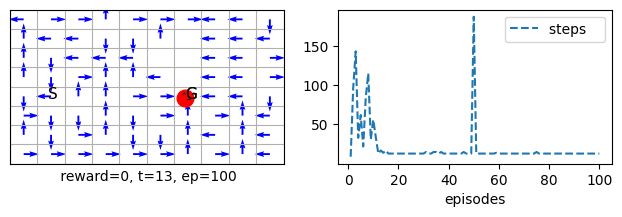

In [60]:
ac = Actor_Critic(env=grid(reward='reward0'), α=1, τ=1, γ=1, episodes=100, seed=0 , **demoQ()).interact()

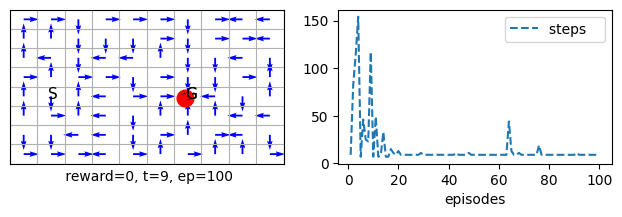

In [61]:
ac = Actor_Critic(env=grid(reward='reward0'), α=1, τ=.9, γ=1, episodes=100, seed=0 , **demoQ()).interact()

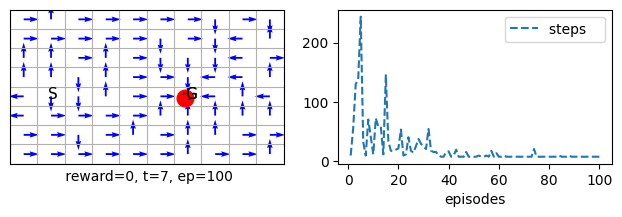

In [62]:
ac = Actor_Critic(env=grid(reward='reward0'), α=.7, τ=1, γ=.98, episodes=100, seed=0 , **demoQ()).interact()

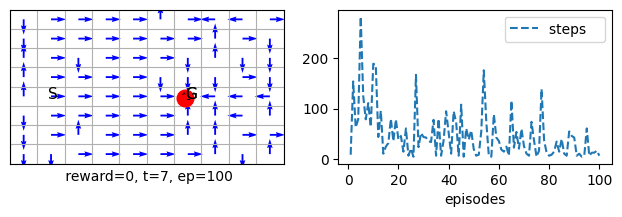

In [63]:
ac = Actor_Critic(env=grid(reward='reward0'), α=.1, τ=1, γ=1, episodes=100, seed=0 , **demoQ()).interact()

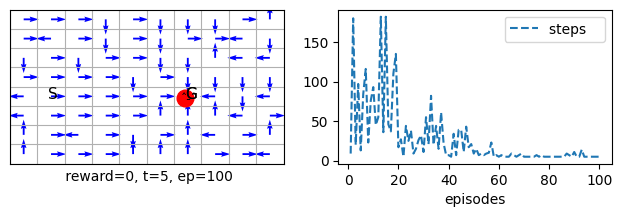

In [64]:
ac = Actor_Critic(env=grid(reward='reward0'), α=.1, τ=.3, γ=1, episodes=100, seed=0 , **demoQ()).interact()

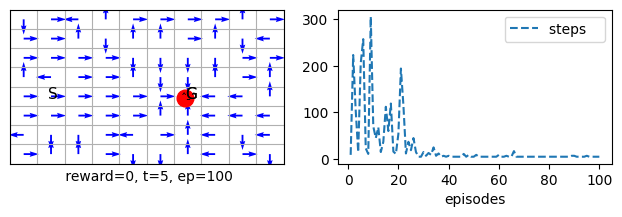

In [65]:
ac = Actor_Critic(env=grid(reward='reward0'), α=.1, τ=.3, γ=.99, episodes=100, seed=0 , **demoQ()).interact()

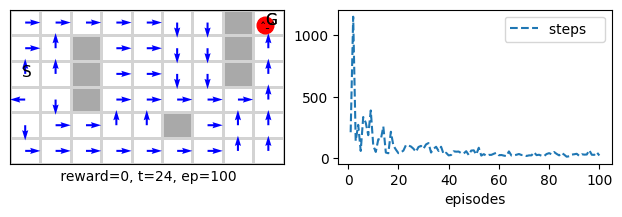

In [66]:
ac = Actor_Critic(env=maze(reward='reward0'), α=.1, τ=1,  γ=1, episodes=100, seed=0 , **demoQ()).interact()

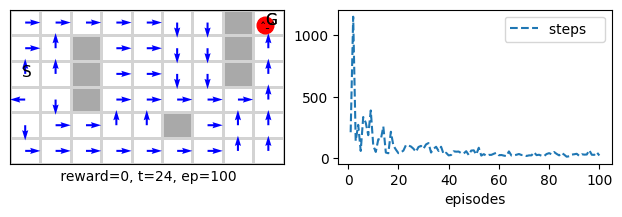

In [67]:
ac = Actor_Critic(env=maze(reward='reward0'), α=.1, τ=1,  γ=1, episodes=100, seed=0 , **demoQ()).interact()

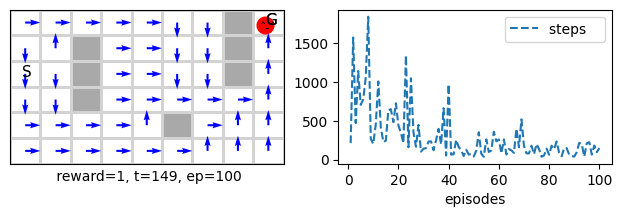

In [68]:
ac = Actor_Critic(env=maze(), α=.1, τ=1,  γ=1,episodes=100, seed=0 , **demoQ()).interact()

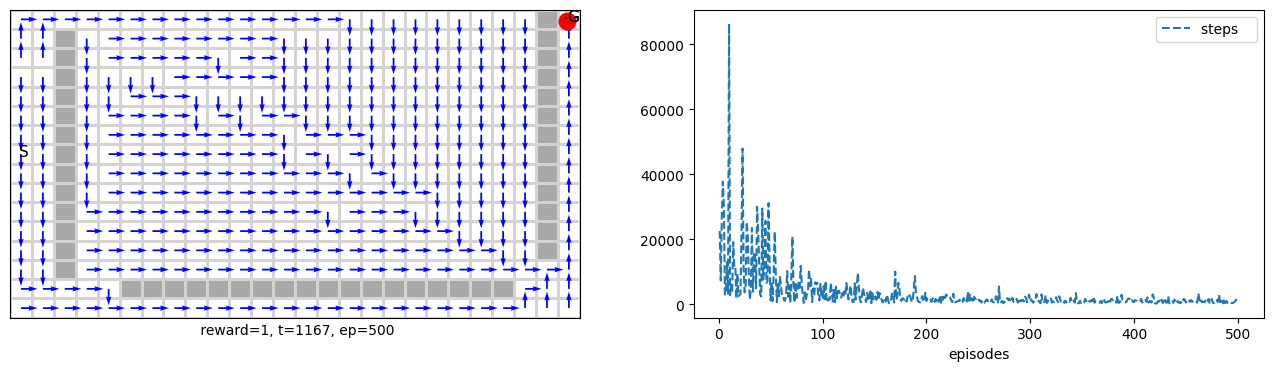

In [69]:
ac_large = Actor_Critic(env=maze_large(), α=.1, τ=1,  γ=1,episodes=500, seed=0 , **demoQ()).interact()

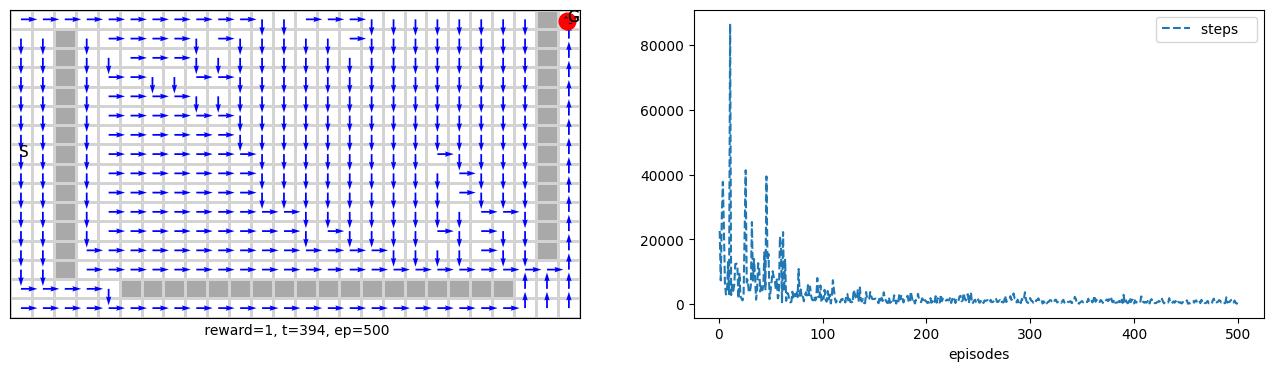

In [70]:
ac_large = Actor_Critic(env=maze_large(), α=.1, τ=.3, γ=1, episodes=500, seed=0 , **demoQ()).interact()

## Model selection: methods comparisons class
Ok, the question is, which one of these algorithms would perform best regardless of the learning rate α? To be able to know, we would need to compare the performances on a set of α values to see the full picture. To that end, we will finally develop a useful comparison class. It will allow us to compare algorithms with different hyperparameters similar to what we did in other machine learning modules. All that is required is to specify which hyperparameter we want to vary and then pass the values we want to test for in a dictionary.

In [71]:
import time

class Compare:
    
    def __init__(self, 
                 algoruns=None,
                 hyper={'α':np.round(np.arange(.1,1,.2),1)},
                 plotR=False, 
                 plotT=False,
                 plotE=False,
                 print=False, 
                 **kw):
        
        self.algoruns = algoruns if algoruns is not None else Runs(**kw)
        self.hyper = hyper
        self.plotR = plotR
        self.plotT = plotT
        self.plotE = plotE
        self.print = print
    
    def isFunction(self, hyperval): 
        return isinstance(hyperval, str) # not in ['α','γ','ε','λ']

    def compare(self, label='',frmt='-', **kw):
            
        algoruns = self.algoruns
        algorithm  = self.algoruns.algorithm
        runs, episodes = algoruns.runs, algorithm.episodes
        
        hypername = list(self.hyper.keys())[0]
        hypervals = list(self.hyper.values())[0]
        nhypervals = len(hypervals)

        self.Rs = np.zeros((nhypervals, runs, episodes))
        self.Ts = np.zeros((nhypervals, runs, episodes))
        self.Es = np.zeros((nhypervals, runs, episodes))
        
        # now call the algorithm for each parameters set
        if self.print: print(algoruns.header())
        start = time.time()
        for h, hyperval in enumerate(hypervals):
            
            if self.isFunction(hyperval):  
                  label_ =   '%s'% hyperval; hyperval = getattr(algorithm, hyperval)
            else: label_ = '%.4f'% hyperval
            setattr(algorithm, hypername, hyperval)

            algoruns.interact(label= '%s %s=%s'%(label, hypername, label_), **kw)
            
            self.Rs[h] = algoruns.Rs
            self.Ts[h] = algoruns.Ts
            self.Es[h] = algoruns.Es
            
            # take the mean over the trials
            results = (algoruns.Rs.mean(), algoruns.Ts.mean(), algoruns.Es.mean())
            if self.print: print(algoruns.values(results))
            # for the progress bar we use a differernt color for compare
            self.comparetime = progress(h, len(hypervals), start, color=2)

        if self.print: print('comparison time = %.2f'% self.comparetime,'\n')
        if self.plotR or self.plotT or self.plotE: self.plot(label=label, frmt=frmt)
            
        return self
            
    def plot(self, label, frmt):
        hypername = list(self.hyper.keys())[0]#'α'
        hypervals = list(self.hyper.values())[0]
        ishyperNum= not self.isFunction(hypervals[0])
        hyperrng  = hypervals if ishyperNum else list(range(len(hypervals)))
        # [.1, .2, .3, .4...,1], ['reward0', 'reward1', 'reward10']

        compareGT = [self.plotR, self.plotT, self.plotE ]
        labels    = ['Rewards', 'Steps', 'Errors']
        cs        = ['r', 'b', 'g']
        
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        
        HyperMeansGT = [self.Rs.mean(axis=(1,2)), self.Ts.mean(axis=(1,2)), self.Es.mean(axis=(1,2))]
        for h, HyperMeans in enumerate(HyperMeansGT):
            
            # plot if it is required
            if not compareGT[h]: continue
            
            if label: plt.plot(hyperrng, HyperMeans, frmt, label=label)
            else:     plt.plot(hyperrng, HyperMeans, cs[h]+'--', label=labels[h])
            plt.xlabel(hypername, fontsize=14)
            plt.legend()
            
            # need to annotate if the hyper parameters are policy or rewards etc
            if ishyperNum: continue  
            bottom, top = plt.ylim()
            for i, hval in enumerate(HyperMeans):
                anot = str(hypervals[i]) +', %s'%hval
                plt.annotate(anot, xy=(i,hval+.1))
                
        
        return self

Now we can compare different α values to specify which algorithm is dominant. This study can be seen in Figure 6.3 in the book. Here we do 10 runs because it takes longer to do more, but you are welcome to try to run it for 100 runs. Note that the asymptotic study will run for 1000. the idea here is to compare the performances of the above control algorithms and variants of Q-learning and Sarsa in a systematic manner. The domain is the cliff walking environment. We want to see which algorithms (Sarsa, expected Sarsa, Q-learning, double Q-learning) perform best regardless of the learning rate. Such comparison would give us a definitive answer on which algorithm is best for the given problem when we see a pattern of dominance for all learning rate values.

100%|██████████████████████████████████████████████████████████████████████████████████████████|19/19
100%|██████████████████████████████████████████████████████████████████████████████████████████|19/19
100%|██████████████████████████████████████████████████████████████████████████████████████████|19/19
100%|██████████████████████████████████████████████████████████████████████████████████████████|19/19
100%|██████████████████████████████████████████████████████████████████████████████████████████|19/19
100%|██████████████████████████████████████████████████████████████████████████████████████████|19/19


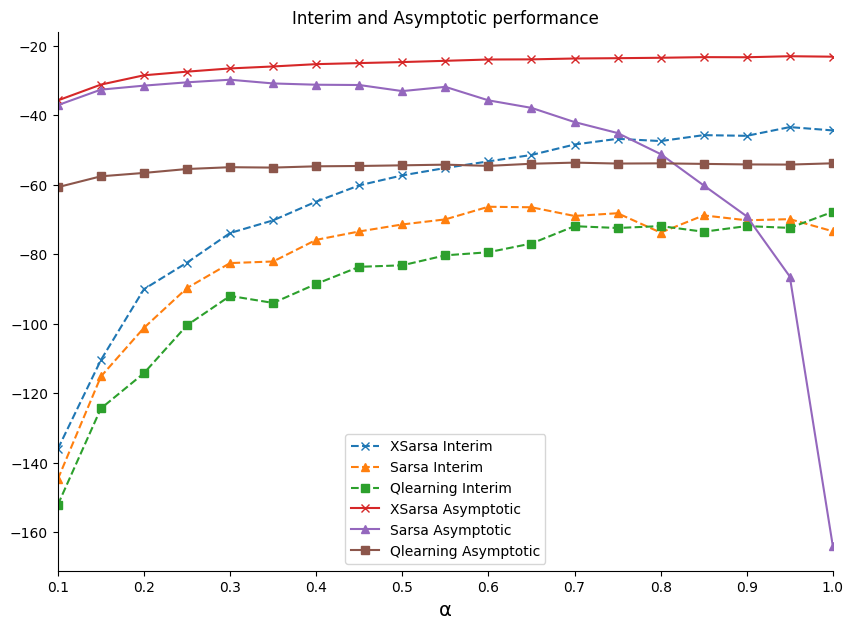

In [72]:
def figure_6_3(runs=10, Interim=True, Asymptotic=True, episodes=100,  label=''): #100
    #plt.ylim(-150, -10)
    plt.xlim(.1,1)
    plt.title('Interim and Asymptotic performance')
    αs = np.arange(.1,1.05,.05)

    
    algors = [ XSarsa,   Sarsa,   Qlearn]#,      DQlearn]
    labels = ['XSarsa', 'Sarsa', 'Qlearning']#, 'Double Q learning']
    frmts  = ['x',      '^',     's']#,         'd']
    
    env = cliffwalk()
    Interim_, Asymptotic_ = [], []
    # Interim perfromance......
    if Interim:
        for g, algo in enumerate(algors):
            compare = Compare(algorithm=algo(env=env, episodes=episodes), runs=runs, hyper={'α':αs},
                             plotR=True).compare(label=labels[g]+' Interim'+label, frmt=frmts[g]+'--')
            Interim_.append(compare)
    
    # Asymptotic perfromance......
    if Asymptotic:
        for g, algo in enumerate(algors):
            compare = Compare(algorithm=algo(env=env, episodes=episodes*10), runs=runs, hyper={'α':αs}, 
                             plotR=True).compare(label=labels[g]+' Asymptotic'+label, frmt=frmts[g]+'-')
            Asymptotic_.append(compare)
    
    plt.gcf().set_size_inches(10, 7)
    return Interim_, Asymptotic_
    
Interim_, Asymptotic_ = figure_6_3()

As we can see the expected Sarsa performed best in the interim and on the asymptote.

## Conclusion

In this lesson, we have further developed our understanding of important and prominent RL online algorithms that are widely used, all based on the value iteration idea. I.e., we keep improving our policy and refining our value-function iteratively in each step until convergence. All of our algorithms are based on the Temporal Difference method. TD uses bootstrapping in its update; instead of using a true return of a state, it uses the current reward + its own estimation of the return for the next state. It is quite surprising to see how well TD works in practice. TD has been proven to converge to a good solution under some basic conditions regarding the learning rate. In practice, however, we assign a fixed small learning rate that works just fine. It is desirable that the learning rate is not decayed when the environment’s dynamics are expected to change.
We have further used TD update in a few control algorithms. Most notable are the Sarsa and Q-learning. The first is an on-policy, while the latter is an off-policy control algorithm. We have compared all algorithms on different problems, studied their strengths and weaknesses, and how they are expected to behave on a certain problem.

## Your turn

1. Create a class that implements an offline TD algorithm. Take inspiration from the MC class.
2. Change the policy in the XSarsa to softmax, you would need to add the probability function in the MDP that deals with the softmax and then 
3. apply Sarsa and Q-learning on a 8 action maze environment by assigning the env=maze8() and study the differences in the way the agent changes its policy and it behaviour.

## Challenge

You can challenge yourself by trying to implement a dynamic environment that changes its obstacles at a specific episode

[Back to TOC](IntroductionTOC.ipynb)